In [52]:
import os, sys
import pandas as pd
import numpy as np
import math
from scipy.signal import get_window
from scipy.fftpack import ifft
import IPython.display as ipd
import matplotlib.pyplot as plt


In [53]:
def closest_up_2_power(n):
    return int(2**math.ceil(math.log(n, 2)))

In [67]:
# importing Image class from PIL package 
from PIL import Image 
  
# opening a multiband image (RGB specifically) 
im = Image.open('/home/user/Downloads/image3.jpg') 
  
# split() method 
# this will split the image in individual bands 
# and return a tuple 

  
# showing each band 
width, height = im.size 

H = 128

M = closest_up_2_power(max(width,height))
N = 2048
window = 'blackmanharris'

N_synth = M+1
frame_size = min(width,height)

# resize image
im = im.resize((frame_size, N_synth))
im1 = Image.Image.split(im)
if width < height:
    R = np.array(im1[0]).T
    G = np.array(im1[1]).T
    B = np.array(im1[2]).T
else:
    R = np.array(im1[0])
    G = np.array(im1[1])
    B = np.array(im1[2])

In [68]:
print(M,N)

4096 2048


In [69]:
def plot_spectrogram(xmX, M, N, H, fs):
    # part of the code is from sms-tools/lectures/04-STFT/plots-code/spectrogram.py:
    plt.figure(1, figsize=(15, 10))

    plt.subplot(211)
    numFrames = int(xmX[:,0].size)
    frmTime = H*np.arange(numFrames)/fs                            
    binFreq = np.arange(N/2+1)*float(fs)/N                         
    plt.pcolormesh(frmTime, binFreq, np.transpose(xmX))
    plt.title('xmX, M=' + str(M) + ', N=' + str(N) + ', H=' + str(H))
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

In [70]:
min_db = np.min([R, G, B])
max_db = np.max([R, G, B])



# transform the 0..255 RGB ranges to -100..0db with a linear function y = mx + n
min_target = -100
max_target = 0

# n
target_range = - np.abs(max_target - min_target)
# m
slope = target_range / max_db

In [71]:
print(frame_size, N_synth)
print(R.shape)

2128 4097
(2128, 4097)


In [72]:



R_cropped = R * slope + target_range
G_cropped = G * slope + target_range
B_cropped = B * slope + target_range


# R_cropped = np.zeros([frame_size,N_synth])
# G_cropped = np.zeros([frame_size,N_synth])
# B_cropped = np.zeros([frame_size,N_synth])

# i = 0
# while i < R.shape[0]:
#     # y = mx + n
#     R_cropped[i] = R[i][0:N_synth] * slope + target_range
#     G_cropped[i] = G[i][0:N_synth] * slope + target_range
#     B_cropped[i] = B[i][0:N_synth] * slope + target_range
#     i += 1

In [73]:
R_cropped.shape
sr = 16000.0

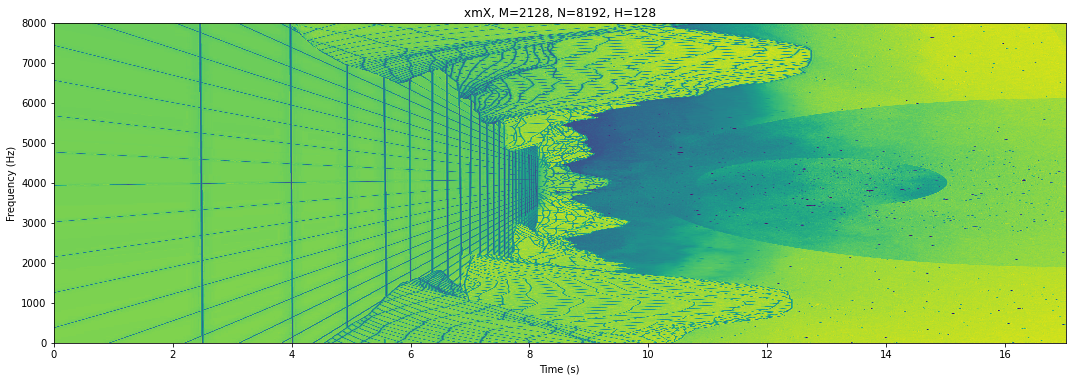

In [74]:
plot_spectrogram(R_cropped+G_cropped+B_cropped, frame_size, 2*M, H, sr)

In [75]:
def dftSynth(mX, pX, M):
	"""
	Synthesis of a signal using the discrete Fourier transform
	mX: magnitude spectrum, pX: phase spectrum, M: window size
	returns y: output signal
	"""

	hN = mX.size                                            # size of positive spectrum, it includes sample 0
	N = (hN-1)*2                                            # FFT size
	if not(((N & (N - 1)) == 0) and N > 0):                                 # raise error if N not a power of two, thus mX is wrong
		raise ValueError("size of mX is not (N/2)+1")

	hM1 = int(math.floor((M+1)/2))                          # half analysis window size by rounding
	hM2 = int(math.floor(M/2))                              # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	y = np.zeros(M)                                         # initialize output array
	Y = np.zeros(N, dtype = complex)                        # clean output spectrum
	Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # generate positive frequencies
	Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # generate negative frequencies
	fftbuffer = np.real(ifft(Y))                            # compute inverse FFT
	y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
	y[hM2:] = fftbuffer[:hM1]
	return y

In [76]:
def stftSynth(mY, pY, M, H) :
	"""
	Synthesis of a sound using the short-time Fourier transform
	mY: magnitude spectra, pY: phase spectra, M: window size, H: hop-size
	returns y: output sound
	"""
	hM1 = (M+1)//2                                   # half analysis window size by rounding
	hM2 = M//2                                       # half analysis window size by floor
	nFrames = mY[:,0].size                           # number of frames
	y = np.zeros(nFrames*H + hM1 + hM2)              # initialize output array
	pin = hM1                  
	for i in range(nFrames):                         # iterate over all frames      
		y1 = dftSynth(mY[i,:], pY[i,:], M)       # compute idft
		y[pin-hM1:pin+hM2] += H*y1                   # overlap-add to generate output sound
		pin += H                                     # advance sound pointer
	y = np.delete(y, range(hM2))                     # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))      # delete the end of the sound that was added in stftAnal
	return y

In [77]:
# analyze the sources
R_synth = stftSynth(R_cropped, R_cropped, N, H)
G_synth = stftSynth(G_cropped, G_cropped, N, H)
B_synth = stftSynth(B_cropped, B_cropped, N, H)

# t, R_synth = istft(R_cropped, fs=2*sr, window='blackman')

# mix the sources (stereo)
x = [R_synth, G_synth] + B_synth*0.7

In [78]:
R_synth.shape

(272384,)

In [79]:
ipd.display(ipd.Audio(x, rate=sr))